# Data preprocessing

## Setup

In [1]:
import qiskit
import qiskit_algorithms

import torch
from torch import cat, no_grad, manual_seed

import pandas as pd

import matplotlib.pyplot as plt

from src.utils import plot_doodle

## Load datasets

In [2]:
camera_df = pd.read_json('../data/full_simplified_camera.ndjson', lines=True)
phone_df = pd.read_json('../data/full_simplified_cell phone.ndjson', lines=True)

for df in [camera_df, phone_df]:
    df.drop(["timestamp", "countrycode", "key_id", "recognized"], axis=1, inplace=True)

In [3]:
phone_df

,word,drawing
0,cell phone,"[[[9, 9], [32, 32]], [[9, 12, 8, 9, 6, 8, 0, 9..."
1,cell phone,"[[[31, 6, 0, 94, 119, 144, 151, 173, 54, 32, 2..."
2,cell phone,"[[[33, 98, 154, 168, 177, 178, 170, 149, 118, ..."
3,cell phone,"[[[76, 81, 82, 71, 56, 35, 0, 31, 46, 64, 71, ..."
4,cell phone,"[[[26, 1, 0, 9, 142, 154, 154, 145, 144, 140, ..."
...,...,...
121125,cell phone,"[[[255, 243, 215, 193, 152, 140, 134, 117, 100..."
121126,cell phone,"[[[0, 15, 20, 34, 42, 55, 87, 113, 174, 185, 1..."
121127,cell phone,"[[[3, 4, 0, 0, 8, 17, 31, 104, 132, 138, 152, ..."
121128,cell phone,"[[[4, 35, 80, 104, 120, 126, 139, 141, 143, 13..."


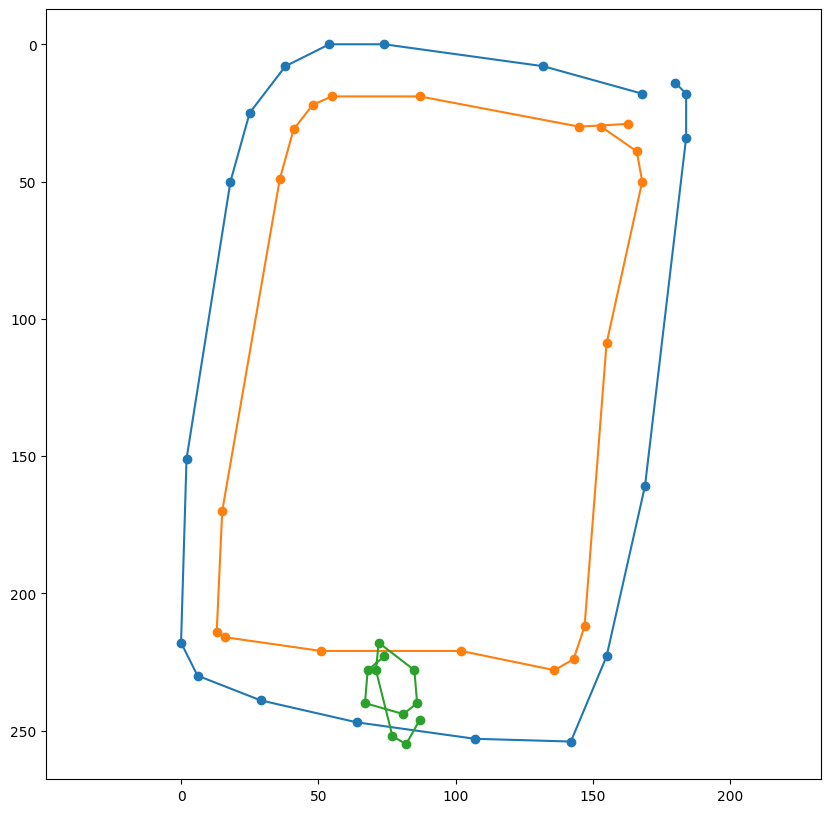

In [4]:
# Line coordinates for the drawing
lines = phone_df['drawing'].iloc[34]
plot_doodle(lines)

In [ ]:
def scale_down_coordinate(coordinate, old_size, new_size):
    """
    Scale down a single coordinate from old_size to new_size.

    Parameters:
    coordinate (int): The coordinate (x or y) to be scaled down.
    old_size (int): The original size of the image (width/height).
    new_size (int): The target size of the image (width/height).

    Returns:
    int: Scaled down coordinate.
    """
    scale_factor = new_size / old_size
    return int(coordinate * scale_factor)

def draw_line(image, start, end):
    """
    Draw a line on the image using Bresenham's line algorithm.

    Parameters:
    image (list of list of int): The image array to draw the line on.
    start (tuple): The starting coordinate of the line.
    end (tuple): The ending coordinate of the line.
    """
    # Bresenham's line algorithm implementation
    # This is a simplified version without anti-aliasing

    x0, y0 = start
    x1, y1 = end
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        if 0 <= x0 < len(image) and 0 <= y0 < len(image):
            image[y0][x0] = 255  # Set the pixel value to white
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

def convert_sketch_to_image(sketch, old_size=255, new_size=28):
    """
    Convert a sketch to a grayscale image.

    Parameters:
    sketch (list): The sketch represented as a list of line segments with coordinates.
    old_size (int): The original size of the sketch area.
    new_size (int): The desired size of the output image.

    Returns:
    list of list of int: The resulting grayscale image.
    """
    image = [[0 for _ in range(new_size)] for _ in range(new_size)]  # Create a blank image

    for segment in sketch:
        x_coords, y_coords = segment
        scaled_x = [scale_down_coordinate(x, old_size, new_size) for x in x_coords]
        scaled_y = [scale_down_coordinate(y, old_size, new_size) for y in y_coords]
        for i in range(len(scaled_x) - 1):
            draw_line(image, (scaled_x[i], scaled_y[i]), (scaled_x[i + 1], scaled_y[i + 1]))

    return image

def print_image(image):
    """
    Print the image as ASCII art.

    Parameters:
    image (list of list of int): The image to print.
    """
    for row in image:
        print(''.join(['#' if pixel else ' ' for pixel in row]))

# Example sketch data for a cell phone
cell_phone_sketch = [
    [[9, 9], [32, 32]],
    [[9, 12, 8, 9, 6, 8, 0, 9, 64, 109, 114, 136, 150, 155, 150, 153, 150, 149, 135, 93, 28, 14, 11, 14, 12], [32, 72, 124, 144, 156, 186, 244, 250, 253, 250, 253, 255, 247, 199, 139, 81, 24, 20, 12, 2, 3, 6, 11, 29, 44]],
    [[12, 145, 147], [47, 50, 53]],
    [[8, 14, 70, 102, 141, 147], [206, 212, 213, 217, 216, 219]],
    [[87, 76, 67, 62, 66, 76, 88, 89, 87, 76], [228, 225, 226, 235, 240, 243, 229, 225, 220, 220]],
    [[68, 100], [24, 24]]
]

# Convert the sketch to a grayscale image and print it
image = convert_sketch_to_image(cell_phone_sketch)
print(image)
print_image(image)